# Overview

This notebook will apply EOF analysis to regridded V20 SSH data via a Jupyter Notebook using ferretmagic.  Many thanks to Patrick Brockmann and the [ferretmagic documentation](https://github.com/PBrockmann/C-CASCADES_notebooks/blob/master/ferretBasics.ipynb) for providing an excellent starting point!  Also thanks to the Ferret Development Team for their [EOF example](https://ferret.pmel.noaa.gov/Ferret/documentation/ferret-eof-demo).  More details on the EOFSVD code are [here](https://ferret.pmel.noaa.gov/Ferret/documentation/users-guide/appendix-a-external-functions/EOF-SPACE#_eofsvd_space).  First we start ferretmagic, load the data into PyFerret, and compute the EOF.  Then, we plot the first few EOF/PC pairings and offer some initial interpretation.

# Some thoughts on computational resources

With 1 degree, monthly data, 1958-2009, we're using about 1.5GB RAM (.9GB app + 0.6GB baseline), runs in a few minutes.  Going to 0.5 degree, we'd quadruple the data (double in each x,y direction) => 0.9 x 4 = 3.6GB + 0.6GB estimate.  Going to 0.25 degree, quadruple again => 3.6 x 4 = 14.4GB + 0.6.  That doesn't count container baseline RAM.

In [1]:
%load_ext ferretmagic

In [2]:
%%ferret

cancel data/all
!use /home/jovyan/data/1_mesh_mask.nc
!use /home/jovyan/data/V20_1948_2009_SSH.nc
use /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_monthly.nc
use /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_annual.nc
use /home/jovyan/data/1p00deg_trial01/
!use coads_climatology
!use V20_1958_2009_SSH_regridded.nc
set memory /size=2000
show data


currently SET data sets:
 1> /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_monthly.nc
 name title I J K L
 TIME ... ... ... 1:624
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:624
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...
 
 2> /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_annual.nc (default)
 name title I J K L
 TIME ... ... ... 1:52
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:52
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...

# Sample plot of data

! Enter_GO land
! Exit_GO


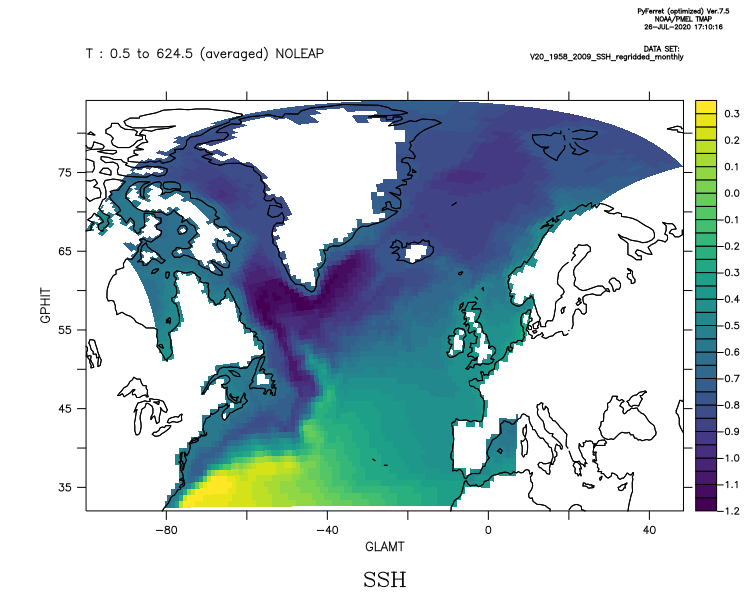

In [3]:
%%ferret
shade /i=2:2000 /j=2:2000 ssh[d=1,l=@AVE],glamt[d=1],gphit[d=1]; go land

Find the difference between the true (uniform weighted)
mean of all 5-day snapshots and the mean of all months
(with the last month having 7 5-day intervals instead of
6 5-day intervals in the other months.)

The result is within \[-0.065,0.04\] m or within 10% over
most of the domain.  The biggest deviations are over the
Gulf Stream.  These deviations are broadly within the range
of the altimeter error (see HR04, 4cm).

In [ ]:
%%ferret
shade /i=2:2000 /j=2:2000 /levels=(-inf)(-10,10,1)(inf) 100*(ssh[d=1,l=@AVE]-ssh[d=2,l=@AVE])/ssh[d=1,l=@AVE],glamt,gphit; go land

# Run EOF

In [ ]:
%%ferret
let ssh_anom = ssh[d=1]-ssh[d=1,l=@AVE]
let eof_time = eofsvd_tfunc(ssh_anom)
save /clobber /file=eof_time.nc eof_time


In [ ]:
%%ferret
let eof_space = eofsvd_space(ssh_anom)
save /clobber /file=eof_space.nc eof_space


In [ ]:
%%ferret
let eof_stat = eofsvd_stat(ssh_anom)
save /clobber /file=eof_stat.nc eof_stat


In [6]:
%%ferret
use /home/jovyan/data/1p00deg_trial01/eof_time.nc
use /home/jovyan/data/1p00deg_trial01/eof_space.nc
use /home/jovyan/data/1p00deg_trial01/eof_stat.nc
sh d

currently SET data sets:
 1> /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_monthly.nc
 name title I J K L
 TIME ... ... ... 1:624
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:624
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...
 
 2> /home/jovyan/data/1p00deg_trial01/V20_1958_2009_SSH_regridded_annual.nc
 name title I J K L
 TIME ... ... ... 1:52
 (invalid coordinate axis)
 SSH 1:89 1:85 ... 1:52
 GLAMT 1:89 1:85 ... ...
 GPHIT 1:89 1:85 ... ...
 
 3> /home/jovyan/data/1p00deg_trial01/eof_time.nc
 name title I J K L
 TIME ... ... ... 1:624
 (invalid coordinate axis)
 EOF_TIME EOFSVD_TFUNC(SSH_ANOM) 1:7565 ... ... 1:624
 (T=0.5:624.5)
 
 4> /home/jovyan/data/1p00deg_trial01/eof_space.nc
 name title I J K L
 EOF_SPACE
 EOFSVD_SPACE(SSH_ANOM) 1:89 1:85 ... 1:7565
 
 5> /home/jovyan/data/1p00deg_trial01/eof_stat.nc (default)
 name title I J K L
 EOF_STAT EOFSVD_STAT(SSH_ANOM) 1:7565 1:3 ... ...

In [7]:
%%ferret
! List the percent variance explained for each EOF
list eof_stat[d=5,i=1:10,j=2]


VARIABLE : EOFSVD_STAT(SSH_ANOM)
 FILENAME : eof_stat.nc
 FILEPATH : /home/jovyan/data/1p00deg_trial01/
 SUBSET : 10 points (X)
 Y : 2
 2 
 2
 1 / 1: 31.10
 2 / 2: 5.83
 3 / 3: 5.16
 4 / 4: 3.90
 5 / 5: 2.66
 6 / 6: 2.08
 7 / 7: 1.81
 8 / 8: 1.71
 9 / 9: 1.46
 10 / 10: 1.42

# Initial thoughts and interpretation

1. EOF 1 -> highly seasonal, next to no long term variability and very weak EOF amplitude.  Is this the seasonal heating of the upper ocean and possible spin-up and spin-down of eddy driven recirculations due to increased/decreased impact of the wind forcing?  Why is there no seasonal signal in the 1st EOF of the observational data? (HR04)  Perhaps the HR04 data is too short to pick this up?  Or was it deseasonalized and that was not explicitly mentioned in the paper?

2. EOF 2 -> Similar to SPG index in spatial map, but the time series is in the opposite sign (SPG increases in strength over the 1990's and 2000's.  End of 1992 -> time index 420, 2000 -> time index 526, 2009 -> time index 624

3. EOF 3 -> Highly seasonal, low long term variability (like EOF1) which has basin-interior changes in SSH (poles on shelves and over Gulf Stream -> Tal Ezer's work?).

4. EOF 4 -> Probably the closest to the "SPG index" in terms of spatial map and time series.

5. EOF 5 -> Some interesting interannual variability, possibly Gulf Stream strength.

! Enter_GO fland
! Exit_GO
! Enter_GO fland
! Exit_GO


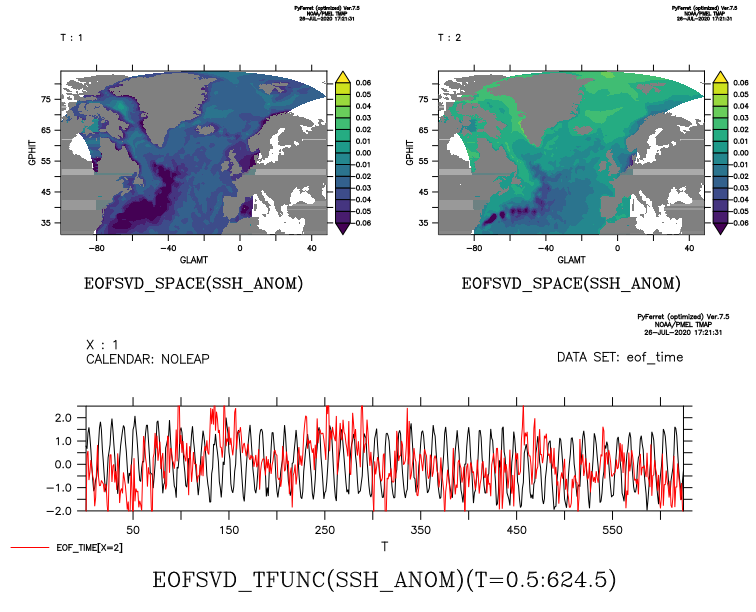

In [18]:
%%ferret
set view ul
fill /levels=(-inf)(-0.06,0.06,0.01)(inf) eof_space[d=4,l=1],glamt[d=1],gphit[d=1]; go fland
set view ur
fill /levels=(-inf)(-0.06,0.06,0.01)(inf) eof_space[d=4,l=2],glamt[d=1],gphit[d=1]; go fland
set view lower
plot eof_time[d=3,i=1]
plot /over /color=2 eof_time[d=3,i=2]


! Enter_GO fland
! Exit_GO
! Enter_GO fland
! Exit_GO


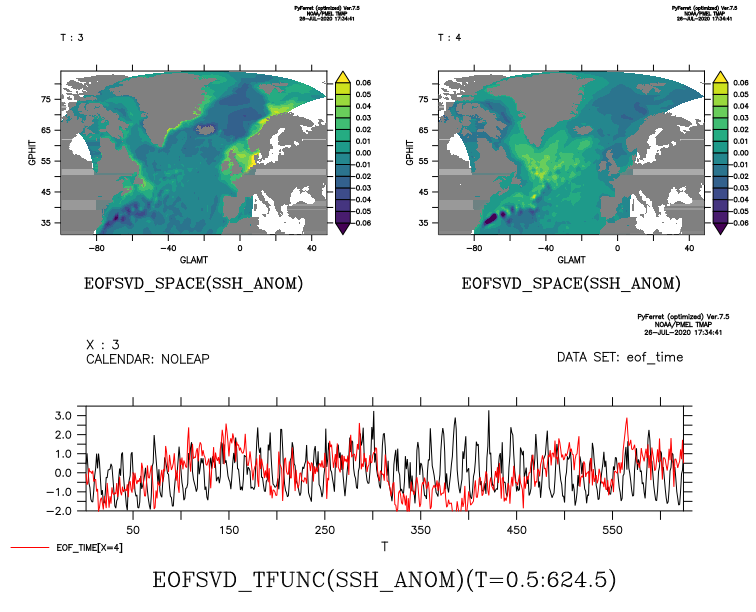

In [20]:
%%ferret
set view ul
fill /levels=(-inf)(-0.06,0.06,0.01)(inf) eof_space[d=4,l=3],glamt[d=1],gphit[d=1]; go fland
set view ur
fill /levels=(-inf)(-0.06,0.06,0.01)(inf) eof_space[d=4,l=4],glamt[d=1],gphit[d=1]; go fland
set view lower
plot eof_time[d=3,i=3]
plot /over /color=2 eof_time[d=3,i=4]

# Next steps

1. There's a long term drift in VIKING20 SSH.  Do we first edit that out?
2. Do we remove a seasonal climatology or a constant climatology from the anomalies?